/home/ardie85/PHD/Research/code/.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


Episode 0
Step 1 of Episode 0
Step 2 of Episode 0
Step 3 of Episode 0
Step 4 of Episode 0
Step 5 of Episode 0
Step 6 of Episode 0
Step 7 of Episode 0
Step 8 of Episode 0
Step 9 of Episode 0
Step 10 of Episode 0
Step 11 of Episode 0
Step 12 of Episode 0
Step 13 of Episode 0
Step 14 of Episode 0
Step 15 of Episode 0
Step 16 of Episode 0
Step 17 of Episode 0
Step 18 of Episode 0
Step 19 of Episode 0
Step 20 of Episode 0
Step 21 of Episode 0
Step 22 of Episode 0
Step 23 of Episode 0
Step 24 of Episode 0
Step 25 of Episode 0
Step 26 of Episode 0
Step 27 of Episode 0
Step 28 of Episode 0
Step 29 of Episode 0
Step 30 of Episode 0
Step 31 of Episode 0
Step 32 of Episode 0
Step 33 of Episode 0
Step 34 of Episode 0
Step 35 of Episode 0
Step 36 of Episode 0
Step 37 of Episode 0
Step 38 of Episode 0
Step 39 of Episode 0
Step 40 of Episode 0
Step 41 of Episode 0
Step 42 of Episode 0
Step 43 of Episode 0
Step 44 of Episode 0
Step 45 of Episode 0
Step 46 of Episode 0
Step 47 of Episode 0
Step 48 of E

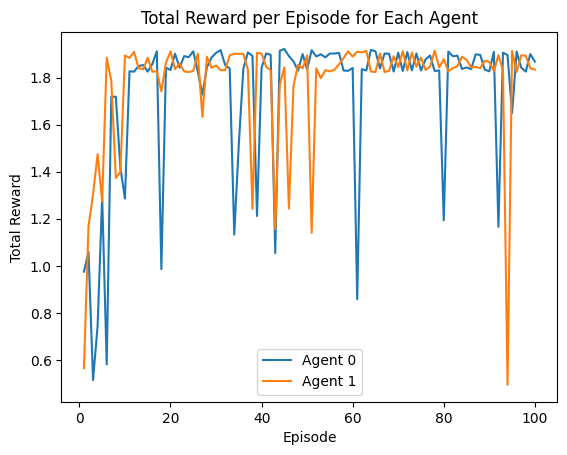

MoviePy - Building file navigation_comm.gif with imageio.


: 

In [1]:
import time
import torch
from vmas import make_env
from vmas.simulator.core import Agent
from vmas.simulator.scenario import BaseScenario
from typing import Union
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML, display as ipython_display
import numpy as np
import matplotlib.pyplot as plt
from gym.spaces import Discrete 

class QLearningAgent:
    def __init__(self, env, agent_id, alpha=0.1, gamma=0.99, epsilon=0.2, communication_weight=0.5):
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = {}
        self.env = env
        self.agent_id = agent_id
        self.communication_weight = communication_weight  # Weight parameter for incorporating messages

    def get_action(self, agent, env, agent_id, agent_obs):
        agent_obs_cpu = agent_obs[:6].cpu().numpy()  # Transfer only the required slice to CPU
        agent_obs = tuple(np.round(agent_obs_cpu, decimals=5))  # Round the observation

        if agent_obs not in self.q_table:
            self.q_table[agent_obs] = np.zeros(self.env.action_space[self.agent_id].n)
        
        # self.print_q_table()

        if np.random.rand() < self.epsilon:
            # Select a random action
            action = np.random.randint(env.action_space[self.agent_id].n)
            # print(f"Agent {agent_id} - action type is random, for obs {agent_obs}= {action}")    
        else:
            # Select the action with the highest Q-value
            action = np.argmax(self.q_table[agent_obs])
            # print(f"Agent {agent_id} - action type is max action, for obs {agent_obs}= {action}") 
        
        return (action,)  # Return as a tuple

    def update_q_table(self, obs, action, reward, next_obs):
        obs_key = tuple(np.round(obs.cpu().numpy(), decimals=5))  # Only transfer to CPU when necessary
        next_obs_key = tuple(np.round(next_obs.cpu().numpy(), decimals=5))
        action = int(action.item())  # Convert tensor to Python scalar

        # print (f"reward obtained = {reward}")

        if isinstance(self.env.action_space[self.agent_id], Discrete):
            action_space_size = self.env.action_space[self.agent_id].n
        else:
            raise ValueError("This Q-learning implementation requires a discrete action space.")

        if obs_key not in self.q_table:
            self.q_table[obs_key] = np.zeros(action_space_size)

        if next_obs_key not in self.q_table:
            self.q_table[next_obs_key] = np.zeros(action_space_size)

        best_next_action = np.argmax(self.q_table[next_obs_key])
        td_target = reward + self.gamma * self.q_table[next_obs_key][best_next_action]

        td_error = td_target - self.q_table[obs_key][action]
        self.q_table[obs_key][action] += self.alpha * td_error

        # print(f"new value of q-table {obs_key} - {action} = {self.q_table[obs_key][action]}")
        
    
    def print_q_table(self):
        for state, actions in self.q_table.items():
            print(f"State: {state}")
            for action, q_value in enumerate(actions):
                print(f"  Action: {action}, Q-value: {q_value}")

class VMASEnvRunner:
    def __init__(
        self,
        render: bool,
        num_envs: int,
        num_episodes: int,
        max_steps_per_episode: int,
        device: str,
        scenario: Union[str, BaseScenario],
        continuous_actions: bool,
        random_action: bool,
        n_agents: int,
        obs_discrete: bool = False,
        **kwargs
    ):
        self.render = render
        self.num_envs = num_envs
        self.num_episodes = num_episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.device = device
        self.scenario = scenario
        self.continuous_actions = continuous_actions
        self.random_action = random_action
        self.obs_discrete = obs_discrete
        self.kwargs = kwargs
        self.frame_list = []  
        self.q_learning_agents = []
        self.rewards_history = []  
        self.action_counts = {i: {} for i in range(n_agents)}  
        self.agent_rewards_history = {i: [] for i in range(n_agents)}
        self.successful_episodes = 0

    def discretize(self, data, bins):
        bins = np.array(bins)
        if np.isscalar(data):
            data = np.array([data])
        bin_indices = np.digitize(data, bins) - 1  # np.digitize returns indices starting from 1
        bin_indices = np.clip(bin_indices, 0, len(bins) - 1)  # Ensure indices are within the valid range
        bin_values = bins[bin_indices]
        bin_values = np.round(bin_values, 2)  # Round the bin values to two decimal places
        return bin_indices, bin_values

    def discretize_tensor_slice(self, tensor_slice, bins):
        tensor_np = tensor_slice.cpu().numpy()  # Convert to numpy for easier handling
        indices, values = self.discretize(tensor_np, bins)
        indices = torch.tensor(indices, device=tensor_slice.device)
        values = torch.tensor(values, device=tensor_slice.device)
        return indices, values

    def _get_deterministic_obs(self, env, observation):
        pos_bins = np.linspace(-1, 1, num=21)
        vel_bins = np.linspace(0, 0, num=21)
        lidar_bins = np.linspace(0, 1, num=11)

        pos = observation[0:2]
        vel = observation[2:4]
        goal_pose = observation[4:6]
        comms_data = observation[6:13]
        sensor_data = observation[13:]

        discrete_pos_indices, discrete_pos_values = self.discretize_tensor_slice(pos, pos_bins)
        discrete_vel_indices, discrete_vel_values = self.discretize_tensor_slice(vel, vel_bins)
        discrete_goal_pose_indices, discrete_goal_pose_values = self.discretize_tensor_slice(goal_pose, pos_bins)
        discrete_sensor_data_indices, discrete_sensor_data_values = self.discretize_tensor_slice(sensor_data, lidar_bins)

        concatenated_tensor_values = torch.cat(
            [discrete_pos_values, discrete_vel_values, discrete_goal_pose_values, comms_data, discrete_sensor_data_values],
            dim=0
        )

        return concatenated_tensor_values

    def _get_deterministic_action(self, agent: Agent, env, agent_id, agent_obs):
        if self.continuous_actions:
            if agent.silent:
                action = torch.tensor([[-1, 0.5]], device=env.device)
            else:
                if agent_id == 0:
                    action = torch.tensor([[-1, 0.5, 2]], device=env.device)
                else:
                    action = torch.tensor([[-1, 0.5, 1]], device=env.device)
        else:
            physical_obs = agent_obs[0:6]

            if not agent.silent:
                comm_obs = agent_obs[6:]
            
            physical_action = self.q_learning_agents[agent_id].get_action(agent, env, agent_id, physical_obs)
            physical_action_tensor = torch.tensor(physical_action, device=self.device)

            if agent.silent:
                action = physical_action_tensor
            else:
                physical_obs_tensor = torch.tensor(physical_obs, device=self.device)
                comm_action_tensor = torch.cat([physical_obs_tensor, physical_action_tensor], dim=0) 

                zero_tensor = torch.zeros(6, dtype=torch.float64, device=self.device)
                first_row = torch.cat((physical_action_tensor, zero_tensor))
                action = torch.stack((first_row, comm_action_tensor)).unsqueeze(0)

        return action

    def generate_gif(self, scenario_name):
        fps = 25
        clip = ImageSequenceClip(self.frame_list, fps=fps)
        clip.write_gif(f'{scenario_name}.gif', fps=fps)
        return HTML(f'<img src="{scenario_name}.gif">')

    def plot_action_distribution(self):
        num_agents = len(self.action_counts)

        for agent_id, counts in self.action_counts.items():
            unique_actions, action_counts = np.unique(list(counts.values()), return_counts=True)
            action_dict = dict(zip(unique_actions, action_counts))
            plt.bar(action_dict.keys(), action_dict.values(), label=f'Agent {agent_id}', alpha=0.7)

        plt.xlabel('Action')
        plt.ylabel('Frequency')
        plt.title('Action Distribution for Each Agent')
        plt.legend()
        plt.show()

    def plot_rewards_history(self):
        num_agents = len(self.agent_rewards_history)

        for agent_id, rewards in self.agent_rewards_history.items():
            plt.plot(range(1, self.num_episodes + 1), rewards, label=f'Agent {agent_id}')

        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Reward per Episode for Each Agent')
        plt.legend()
        plt.show()

    def run_vmas_env(self):
        scenario_name = self.scenario if isinstance(self.scenario, str) else self.scenario.__class__.__name__

        env = make_env(
            scenario=self.scenario,
            num_envs=self.num_envs,
            device=self.device,
            continuous_actions=self.continuous_actions,
            seed=0,
            **self.kwargs
        )

        for agent_id, agent in enumerate(env.agents):
            self.q_learning_agents.append(QLearningAgent(env, agent_id, communication_weight=0.5))

        init_time = time.time()
        total_steps = 0

        for e in range(self.num_episodes):
            print(f"Episode {e}")
            obs = env.reset()
            done = [False] * self.num_envs
            step = 0

            # Initialize rewards for each agent for the current episode
            episode_rewards = {i: 0 for i in range(len(self.q_learning_agents))}

            while not all(done) and step < self.max_steps_per_episode:
                step += 1
                total_steps += 1
                print(f"Step {step} of Episode {e}")

                actions = []
                for i, agent in enumerate(env.agents):
                    if self.obs_discrete:
                        discrete_obs = self._get_deterministic_obs(env, obs[i])
                        obs[i] = discrete_obs

                    if self.random_action:
                        action = env.get_random_action(agent)
                    else:
                        action = self._get_deterministic_action(agent, env, i, obs[i])

                    actions.append(action)
                
                next_obs, rews, dones, info = env.step(actions)
                done = [done or d for done, d in zip(done, dones)]

                for i, agent in enumerate(env.agents):
                    if self.obs_discrete:
                        discrete_next_obs = self._get_deterministic_obs(env, next_obs[i])
                        next_obs[i] = discrete_next_obs

                    physical_obs_for_update = obs[i][0:6]
                    physical_nextobs_for_update = next_obs[i][0:6]
                    physical_actions_for_update = actions[i][0, 0, 0].unsqueeze(0)

                    self.q_learning_agents[i].update_q_table(physical_obs_for_update, physical_actions_for_update, rews[i].item(), physical_nextobs_for_update)

                    # Accumulate rewards for each agent within the episode
                    episode_rewards[i] += rews[i].item()

                obs = next_obs

                if self.render:
                    frame = env.render(
                        mode="rgb_array",
                        agent_index_focus=None,
                    )
                    self.frame_list.append(frame)

                # print(f"-------------------------")

            # Update rewards history after each episode
            for agent_id, total_reward in episode_rewards.items():
                self.agent_rewards_history[agent_id].append(total_reward)

            # Check if the episode was successful
            if any(done):
                self.successful_episodes += 1

            torch.cuda.empty_cache()  # Free up unused memory

        total_time = time.time() - init_time
        print(
            f"It took: {total_time}s for {total_steps} steps across {self.num_episodes} episodes of {self.num_envs} parallel environments on device {self.device} "
            f"for {scenario_name} scenario."
        )

        success_percentage = (self.successful_episodes / self.num_episodes) * 100
        print(f"Percentage of successful episodes: {success_percentage}%")

if __name__ == "__main__":
    scenario_name = "navigation_comm"
    use_cuda = True

    env_runner = VMASEnvRunner(
        render=True,
        num_envs=1,
        num_episodes=50,
        max_steps_per_episode=200,
        device = torch.device("cuda" if use_cuda else "cpu"),
        scenario=scenario_name,
        continuous_actions=False,
        random_action=False,
        n_agents=2,
        obs_discrete=True,
        agents_with_same_goal=2,
        collisions=False,
        shared_rew=False,
    )

    env_runner.run_vmas_env()
    # for agent in env_runner.q_learning_agents:
    #     agent.print_q_table()
    env_runner.plot_rewards_history()

    ipython_display(env_runner.generate_gif(scenario_name))
    
    